In [36]:
import os
import random
import argparse
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from config.config_run import *
from models.AMIO import AMIO
from data.load_data import MMDataLoader

In [2]:
class Storage(dict):
    """
    A Storage object is like a dictionary except `obj.foo` can be used inadition to `obj['foo']`
    ref: https://blog.csdn.net/a200822146085/article/details/88430450
    """
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __str__(self):
        return "<" + self.__class__.__name__ + dict.__repr__(self) + ">"

In [28]:
seed = 1111
args = {'modelName': 'dmult', 'datasetName': 'mosi', 'num_workers': 8, 'tasks': 'M', \
        'data_dir': '/home/sharing/disk3/dataset/multimodal-sentiment-dataset'}
# save_path = 'asserts' + '/' + args['modelName'] + '-%d' % seed + '.pdf'
config = Config(args)
args = config.get_config()
device = torch.device('cuda: 1')
# load model
model_save_path = '/home/iyuge2/Project/MSA-AAAI2021/results/tmpSave/dmult-mosi-M-A-B.pth'
model = AMIO(args)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()
# load data
dataloader = MMDataLoader(args)

Train Samples Num: 1284
Valid Samples Num: 229
Test Samples Num: 686


In [29]:
feature_ts, feature_as, feature_vs, feature_fs = [], [], [], []
new_ts, new_as, new_vs = [], [], []
y_pred = []
y_true = []
with torch.no_grad():
    for mode in ['train', 'valid', 'test']:
        with tqdm(dataloader[mode]) as td:
            for batch_data in td:
                vision = batch_data['vision'].to(device)
                audio = batch_data['audio'].to(device)
                text = batch_data['text'].to(device)
                labels = batch_data['labels']['M'].to(device).view(-1, 1)

                outputs = model(text, audio, vision)
                # save features and results
                feature_ts.append(outputs['Feature_t'].cpu().detach())
                feature_as.append(outputs['Feature_a'].cpu().detach())
                feature_vs.append(outputs['Feature_v'].cpu().detach())
                feature_fs.append(outputs['Feature_f'].cpu().detach())
                
#                 new_ts.append(outputs['New_t'].cpu().detach())
#                 new_as.append(outputs['New_a'].cpu().detach())
#                 new_vs.append(outputs['New_v'].cpu().detach())
                
                y_pred.append(outputs['M'].cpu())
                y_true.append(labels.cpu())

100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


In [30]:
feature_T = torch.cat(feature_ts, dim=0).cpu().detach().numpy()
feature_A = torch.cat(feature_as, dim=0).cpu().detach().numpy()
feature_V = torch.cat(feature_vs, dim=0).cpu().detach().numpy()
feature_F = torch.cat(feature_fs, dim=0).cpu().detach().numpy()
# new_T = torch.cat(new_ts, dim=0).cpu().detach().numpy()
# new_A = torch.cat(new_as, dim=0).cpu().detach().numpy()
# new_V = torch.cat(new_vs, dim=0).cpu().detach().numpy()

y_pred = torch.cat(y_pred, dim=0).view(-1).cpu().detach().numpy()
y_pred[y_pred > 0] = 1
y_pred[y_pred <= 0] = 0

y_true = torch.cat(y_true, dim=0).view(-1).cpu().detach().numpy()
y_true[y_true > 0] = 1
y_true[y_true <= 0] = 0

- 融合表示

In [ ]:
result_F = tsne.fit_transform(feature_F)
pos = result_F[np.where(y_true==1)]
neg = result_F[np.where(y_true==0)]
plt.scatter(pos[:,0], pos[:,1], color='r', label='pos')
plt.legend()
plt.scatter(neg[:,0], neg[:,1], color='g', label='neg')
plt.legend()

- 单模态表示

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
plt.rcParams['font.sans-serif'] = ['Times New Roman']
tsne = TSNE(n_components=2, init='pca', random_state=0)
result_T = tsne.fit_transform(feature_T)
result_A = tsne.fit_transform(feature_A)
result_V = tsne.fit_transform(feature_V)
att_xs = [result_T, result_A, result_V]

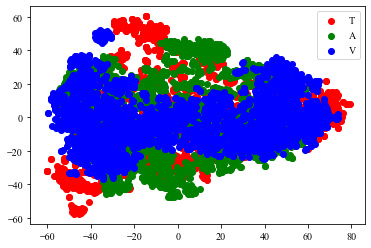

In [7]:
colors = ['r', 'g', 'b']
labels = ['T', 'A', 'V']
for i in range(len(colors)): 
    plt.scatter(att_xs[i][:,0:1], att_xs[i][:,1:2], label=labels[i], c = colors[i])
    plt.legend(loc='upper right')

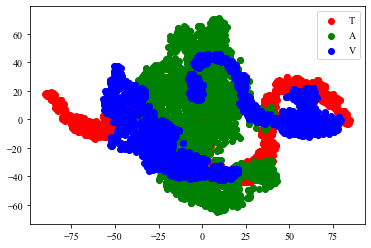

In [8]:
result_T = tsne.fit_transform(new_T)
result_A = tsne.fit_transform(new_A)
result_V = tsne.fit_transform(new_V)
att_xs = [result_T, result_A, result_V]
colors = ['r', 'g', 'b']
labels = ['T', 'A', 'V']
for i in range(len(colors)): 
    plt.scatter(att_xs[i][:,0:1], att_xs[i][:,1:2], label=labels[i], c = colors[i])
    plt.legend(loc='upper right')

In [95]:
def test(x, D):
    x_shape = x.size()
    x = x.view(-1)
    left = x < -D
    middle = (x >= -D) & (x <= D)
    right = x > D
    # x < -D
    x[left] = (1 - torch.exp(-x[left]-D)) / (1 + torch.exp(-x[left]-D))
    # x < D and x > -D
    x[middle] = 0
    # x > D
    x[right] = (1 - torch.exp(-x[right]+D)) / (1 + torch.exp(-x[right]+D))
    # return
    x = x.view(x_shape)
    return x

In [97]:
x = torch.tensor([i for i in range(-5, 5)]).float().view(-1, 2)

In [98]:
x.requires_grad = True

In [99]:
new_x = test(x, 2)

In [100]:
x.requires_grad

True

In [101]:
new_x.requires_grad

True

In [127]:
a = torch.tensor([3.0, 0.0, 1.0])

In [128]:
a.requires_grad = True

In [131]:
b = torch.where(a > 2.0, torch.tensor([0.0]), a)

In [132]:
b.requires_grad

True